In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, exp, pi
from sklearn.naive_bayes import GaussianNB
from scipy.stats import weibull_min, weibull_max, genextreme
import itertools

In [2]:
nb_training = 5

all_frames_uniform = [1, 2, 4, 5, 6, 36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70,
                      72, 74, 76, 78, 80, 84, 86, 87, 100, 142]

all_frames_enriched = [1, 2, 4, 5, 6, 36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70,
                      72, 74, 76, 78, 80, 86, 101, 111, 121, 132]

all_frames_long = [1, 2, 4, 5, 6, 36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70,
                   72, 74, 76, 78, 80, 140, 141, 142]

human_test_ind = [36, 38, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70, 72, 74, 76, 78, 80,]

human_uniform_prob = [0.074786, 0.057692, 0.066239, 0.104701, 0.123932,
                      0.188034, 0.258547, 0.388889, 0.485043, 0.602564,
                      0.690171, 0.782051, 0.856838, 0.884615, 0.899573,
                      0.931624, 0.938034, 0.955128, 0.950855, 0.972222]
human_enrich_prob = [0.119048, 0.062907, 0.075922, 0.097614, 0.132321,
                     0.201735, 0.288503, 0.392625, 0.496746, 0.613883,
                     0.722343, 0.800434, 0.872017, 0.924078, 0.952278,
                     0.952278, 0.958696, 0.976087, 0.973913, 0.980435]

human_long_prob = [0.06572769953051644, 0.018823529411764704, 0.009411764705882352,
                   0.011764705882352941, 0.02358490566037736, 0.030660377358490566,
                   0.04245283018867924, 0.0589622641509434, 0.09669811320754718,
                   0.12028301886792453, 0.18632075471698112, 0.2169811320754717,
                   0.2783018867924528, 0.33490566037735847, 0.42924528301886794,
                   0.5047169811320755, 0.5825471698113207, 0.6279620853080569,
                   0.7156398104265402, 0.7535545023696683]

In [9]:
# Calculate the mean of a list of numbers
def mean(numbers):
    return sum(numbers)/float(len(numbers))

# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)

def get_prob(data_frame,
             classifier):
    """

    :param data_frame:
    :return:
    """
    sample_w_frame = data_frame[["frame", "distance_to_A"]]
    frames = sample_w_frame['frame'].unique()

    prob_dict = {}
    prob_one_frame = []

    for one_frame in frames:
        frames = sample_w_frame.loc[sample_w_frame['frame'] == one_frame]
        dist = frames["distance_to_A"].tolist()

        for one_dist in dist:
            prob = classifier.predict_proba(np.asarray(one_dist).reshape(-1, 1))
            prob_one_frame.append(prob[0][1])

        prob_dict[one_frame] = mean(prob_one_frame)

    return prob_dict

In [10]:
def gaussian_naive_bayes_with_a(data_dir):
    """
    Use class A and class B training data to fit a gaussian model,
    then use bayesian theorem to calculate probability.

    :return:
    """
    # Step 1: Load training data for class A and B, and testing data
    training_a = pd.read_csv(os.path.join(data_dir, "sample_a.csv"))
    training_b = pd.read_csv(os.path.join(data_dir, "sample_b.csv"))
    testing = pd.read_csv(os.path.join(data_dir, "test_samples.csv"))

    # Take feature column for training data and convert data to list
    a_sample = training_a[["distance_to_A"]]
    b_sample = training_b[["distance_to_A"]]

    a_sample = a_sample.distance_to_A.values.tolist()
    b_sample = b_sample.distance_to_A.values.tolist()

    print("Number of samples in class A:", len(a_sample))
    print("Number of samples in class B:", len(b_sample))

    # Step 2: Calculate mean and standard deviation
    mean_a = mean(a_sample)
    sd_a = stdev(a_sample)
    var_a = np.var(np.asarray(a_sample))

    mean_b = mean(b_sample)
    sd_b = stdev(b_sample)
    var_b = np.var(np.asarray(b_sample))

    print("Mean for A: ", mean_a)
    print("SD for A: ", sd_a)
    print("Var for A: ", var_a )
    print("Mean for B: ", mean_b)
    print("SD for B :", sd_b)
    print("Var for B: ", var_b)

    stats = [mean_a, sd_a, var_a, mean_b, sd_b, var_b]

    # Build and fit Gaussian Naive Bayes Model
    clf = GaussianNB()

    X = np.asarray(a_sample + b_sample)
    Y = np.asarray([0] * len(a_sample) + [1] * len(b_sample))
    clf.fit(X.reshape(-1, 1), Y)

    # Training data A
    prob_dict_a = get_prob(data_frame=training_a,
                            classifier=clf)

    # Training data B
    prob_dict_b = get_prob(data_frame=training_b,
                           classifier=clf)

    # Testing data
    prob_dict_test = get_prob(data_frame=testing,
                         classifier=clf)

    # Combine dictionaries and sort
    prob_dict = {**prob_dict_a, **prob_dict_b, **prob_dict_test}
    prob_dict = dict(sorted(prob_dict.items()))

    # print(prob_dict)

    return prob_dict, stats

In [13]:
# VGG-ResNet
uniform_data_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_modeling/vggface_resnet_uniform_nb_train_5_ratio_0.9_tail_weight_0.4"
enriched_tail_data_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_modeling/vggface_resnet_enriched_tail_nb_train_5_ratio_0.9_tail_weight_0.4"
long_tail_data_dir = "/Users/kiyoshi/Desktop/jov_everything/face_morph_v4_5_sets_modeling/vggface_resnet_long_tail_nb_train_5_ratio_0.9_tail_weight_0.4/"

gaussian_prob_uniform, stats_uniform = gaussian_naive_bayes_with_a(data_dir=uniform_data_dir)
# print("Uniform Gaussian prob from sklearn:")
# print(gaussian_prob_uniform)
print("*" * 20)

gaussian_prob_enrich, stats_enrich = gaussian_naive_bayes_with_a(data_dir=enriched_tail_data_dir)
# print("Enriched tail Gaussian prob from sklearn:")
# print(gaussian_prob_enrich)
print("*" * 20)

gaussian_prob_long, stats_long = gaussian_naive_bayes_with_a(data_dir=long_tail_data_dir)



Number of samples in class A: 405
Number of samples in class B: 405
Mean for A:  3.703616092234482
SD for A:  2.2775912337308784
Var for A:  5.174613379009806
Mean for B:  61.67699843983591
SD for B : 10.757943879829265
Var for B:  115.44759514742863
********************
Number of samples in class A: 405
Number of samples in class B: 405
Mean for A:  3.701937891524515
SD for A:  2.312496099296414
Var for A:  5.334434164299987
Mean for B:  65.14013343151704
SD for B : 9.668437326757102
Var for B:  93.24786878503143
********************
Number of samples in class A: 405
Number of samples in class B: 405
Mean for A:  3.7462189020933927
SD for A:  2.3094732998966467
Var for A:  5.320497374977644
Mean for B:  65.30492903156045
SD for B : 9.676513421006394
Var for B:  93.40371467336892


In [14]:
def plot_gaussian_curve(gaussian_prob_uniform,
                        gaussian_prob_enrich,
                        gaussian_prob_long):
    """

    :param prob:
    :return:
    """
    from matplotlib.pyplot import figure

    figure(figsize=(8, 6), dpi=80)
    
    # Gaussian probabilities for uniform and enriched tail
    list_gauss_uniform = sorted(gaussian_prob_uniform.items())
    x_gauss_uniform, y_gauss_uniform = zip(*list_gauss_uniform)

    list_gauss_enrich = sorted(gaussian_prob_enrich.items())
    x_gauss_enrich, y_gauss_enrich = zip(*list_gauss_enrich)
    
    list_gauss_long = sorted(gaussian_prob_long.items())
    x_gauss_long, y_gauss_long = zip(*list_gauss_long)


    # Plot gaussian curves (3 of them)
    plt.plot(x_gauss_uniform[5:25], y_gauss_uniform[5:25], label="Gaussain Uniform", color='red',)
    plt.plot(x_gauss_uniform[5:25], y_gauss_enrich[5:25], label="Gaussain Enriched Tail", color='red', linestyle='dotted',)
    plt.plot(x_gauss_uniform[5:25], y_gauss_long[5:25], label="Gaussain Long Tail", color='red', linestyle='dashed',)

    plt.legend(loc="lower right")


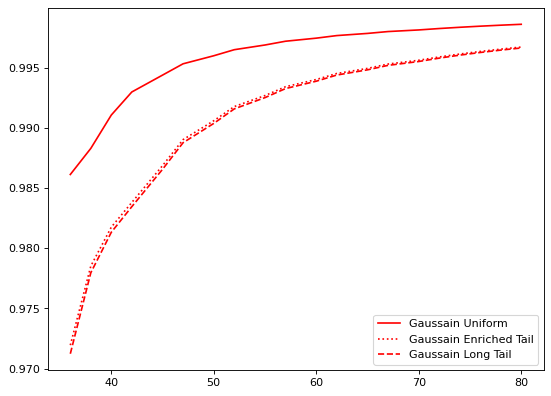

In [15]:
plot_gaussian_curve(gaussian_prob_uniform=gaussian_prob_uniform,
                    gaussian_prob_enrich=gaussian_prob_enrich,
                    gaussian_prob_long=gaussian_prob_long)